<a href="https://colab.research.google.com/github/Rhayem1920/Finding-Eigen-Portfolio-Portfolio-Management-PCA-/blob/main/Finding_Eigen_Portfolio_Portfolio_Management_(PCA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Portfolio Management-Eigen Portfolio**

In this case study we use dimensionality reduction techniques for portfolio management and allocation


## **Problem Definition:**

Our goal in this case study is to maximize risk-adjusted returns using dimensionality reduction-based algorithm on a dataset of stocks to allocate capital into different asset classes.

The dataset used for this case study is Dow Jones Industrial Average (DJIA) index and its respective 30 stocks from year 2000 onwards. The dataset can be downloaded from yahoo finance.


In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

#Import Model Packages 
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from numpy.linalg import inv, eig, svd

from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA

In [2]:
# load dataset
dataset = read_csv('/content/Dow_adjclose.csv',index_col=0)

#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

dataset.head()

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,DWDP,XOM,GS,HD,IBM,INTC,JNJ,JPM,MCD,MRK,MSFT,NKE,PFE,PG,TRV,UTX,UNH,VZ,V,WMT,WBA
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-03,29.847043,35.476634,3.530576,26.650218,14.560887,21.582046,43.003876,16.983583,23.522220,NaN,23.862240,72.316570,45.143382,81.449761,28.525123,28.584797,26.862510,24.393585,32.896986,38.135101,4.701180,16.746856,32.227726,20.158885,21.319030,5.841355,22.564221,NaN,47.337599,21.713237
2000-01-04,28.661131,34.134275,3.232839,26.610431,14.372251,21.582046,40.577200,17.040950,24.899860,NaN,23.405167,67.763517,40.510629,78.683277,27.193951,27.536780,26.280065,23.888848,31.739292,36.846046,4.445214,16.121738,31.596399,19.890099,20.445803,5.766368,21.833915,NaN,45.566248,20.907354
2000-01-05,30.122175,33.959430,3.280149,28.473758,14.914205,22.049145,40.895453,17.228147,25.781550,NaN,24.569179,65.257700,42.761219,81.449761,27.748059,27.964669,26.116927,24.393585,33.198570,37.235380,4.702157,16.415912,31.325831,20.085579,20.254784,5.753327,22.564221,NaN,44.503437,21.097421
2000-01-06,31.877325,33.959430,2.996290,28.553331,15.459153,22.903343,39.781569,17.210031,24.899860,NaN,25.958680,67.354070,41.549363,80.045454,25.820155,28.699520,26.487695,23.931935,33.261805,35.988857,4.677733,16.972739,32.438168,20.122232,20.998392,5.964159,22.449405,NaN,45.126952,20.527220
2000-01-07,32.509812,34.433913,3.138219,29.382213,15.962182,23.305926,42.128682,18.342270,24.506249,NaN,25.882501,67.607927,43.973075,79.694378,26.885748,29.921172,26.973402,24.547469,36.452760,36.459983,4.677733,18.123166,35.023602,20.922479,21.830687,6.662948,22.282692,NaN,48.535033,21.051805


## **Exploratory Data Analysis**


In [3]:
# shape
print(dataset.shape)
# peek at data
set_option('display.width', 100)

# types
set_option('display.max_rows', 500)
dataset.dtypes


(4804, 30)


MMM     float64
AXP     float64
AAPL    float64
BA      float64
CAT     float64
CVX     float64
CSCO    float64
KO      float64
DIS     float64
DWDP    float64
XOM     float64
GS      float64
HD      float64
IBM     float64
INTC    float64
JNJ     float64
JPM     float64
MCD     float64
MRK     float64
MSFT    float64
NKE     float64
PFE     float64
PG      float64
TRV     float64
UTX     float64
UNH     float64
VZ      float64
V       float64
WMT     float64
WBA     float64
dtype: object

In [4]:
# describe data
set_option('precision', 3)
dataset.describe()


,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,DWDP,XOM,GS,HD,IBM,INTC,JNJ,JPM,MCD,MRK,MSFT,NKE,PFE,PG,TRV,UTX,UNH,VZ,V,WMT,WBA
count,4804.000,4804.000,4804.000,4804.000,4804.000,4804.000,4804.000,4804.000,4804.000,363.000,4804.000,4804.000,4804.000,4804.000,4804.000,4804.000,4804.000,4804.000,4804.000,4804.000,4804.000,4804.000,4804.000,4804.000,4804.000,4804.000,4804.000,2741.000,4804.000,4804.000
mean,86.769,49.659,49.107,85.482,56.697,61.735,21.653,24.984,46.368,64.897,54.741,132.889,57.416,104.716,22.284,61.493,41.503,59.954,35.652,31.983,23.724,20.737,49.960,55.961,62.209,64.418,27.193,53.323,50.767,41.697
std,53.942,22.564,55.020,79.085,34.663,31.714,10.074,10.611,32.733,5.768,20.687,52.331,49.243,38.764,10.141,31.651,23.723,44.645,13.826,21.984,20.988,7.630,19.769,34.644,32.627,62.920,11.973,37.647,17.040,19.937
min,25.140,8.713,0.828,17.463,9.247,17.566,6.842,11.699,11.018,49.090,19.491,45.648,14.067,39.242,8.725,21.316,9.839,7.974,14.675,11.908,2.595,8.041,16.204,13.287,14.521,5.175,11.210,9.846,30.748,17.317
25%,51.192,34.079,3.900,37.407,26.335,31.820,14.910,15.420,22.044,62.250,33.381,85.301,25.463,67.954,15.329,39.209,26.374,20.736,25.826,19.158,8.037,15.031,35.414,29.907,34.328,23.498,17.434,18.959,38.062,27.704
50%,63.514,42.274,23.316,58.437,53.048,56.942,18.578,20.563,29.521,66.586,57.193,134.273,30.784,94.119,18.516,47.142,33.032,44.425,30.952,22.477,14.147,18.643,46.735,39.824,55.715,42.924,21.556,45.207,42.782,32.706
75%,122.906,66.816,84.007,112.996,76.488,91.688,24.650,34.927,75.833,69.143,73.712,166.303,72.425,143.030,28.142,85.587,50.476,83.752,46.784,36.172,36.545,25.403,68.135,80.767,92.557,73.171,38.996,76.966,65.076,58.165
max,251.981,112.421,231.260,411.110,166.832,128.680,63.698,50.400,117.973,75.261,88.852,270.419,212.616,178.294,56.023,147.840,116.850,188.510,78.774,115.106,85.300,45.841,98.030,146.564,141.280,286.330,60.016,150.525,107.010,90.188


## **Data Visualization:**

Taking a look at the correlation. More detailed look at the data will be performed after implementing the Dimensionality Reduction Models.



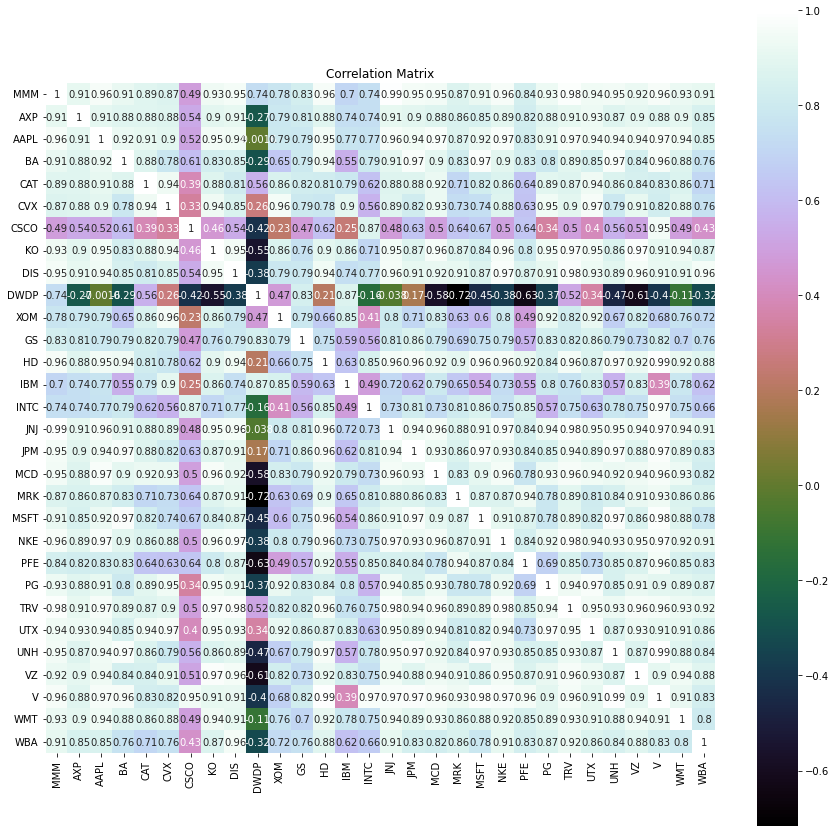

In [5]:
# correlation
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')





**As it can be seen by the chart above, there is a significant positive correlation between the stocks.**

## Data Preparation

#### **Data Cleaning**

Let us check for the NAs in the rows, either drop them or fill them with the mean of the column

In [6]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())



Null Values = True


In [8]:
# Getting rid of the columns with more than 30% missing values.

missing_fractions = dataset.isnull().mean().sort_values(ascending=False)

missing_fractions.head(10)

drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))

dataset.drop(labels=drop_list, axis=1, inplace=True)
dataset.shape



(4804, 28)

In [9]:
#Given that there are null values drop the rown contianing the null values.

# Fill the missing values with the last value available in the dataset. 
dataset=dataset.fillna(method='ffill')

# Drop the rows containing NA
dataset= dataset.dropna(axis=0)
# Fill na with 0
#dataset.fillna('0')

dataset.head(2)



,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,XOM,GS,HD,IBM,INTC,JNJ,JPM,MCD,MRK,MSFT,NKE,PFE,PG,TRV,UTX,UNH,VZ,WMT,WBA
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-03,29.847,35.477,3.531,26.65,14.561,21.582,43.004,16.984,23.522,23.862,72.317,45.143,81.450,28.525,28.585,26.863,24.394,32.897,38.135,4.701,16.747,32.228,20.159,21.319,5.841,22.564,47.338,21.713
2000-01-04,28.661,34.134,3.233,26.61,14.372,21.582,40.577,17.041,24.900,23.405,67.764,40.511,78.683,27.194,27.537,26.280,23.889,31.739,36.846,4.445,16.122,31.596,19.890,20.446,5.766,21.834,45.566,20.907




## **Computing Daily Return:**



In [11]:
# Daily Log Returns (%)
# datareturns = np.log(data / data.shift(1)) 

# Daily Linear Returns (%)
datareturns = dataset.pct_change(1)

#Remove Outliers beyong 3 standard deviation
datareturns= datareturns[datareturns.apply(lambda x :(x-x.mean()).abs()<(3*x.std()) ).all(1)]

### **Data Transformation:**

All the variables should be on the same scale before applying PCA, otherwise a feature with large values will dominate the result. Below we use StandardScaler in sklearn to standardize the dataset’s features onto unit scale (mean = 0 and variance = 1).

Standardization is a useful technique to transform attributes to a standard Normal distribution with a mean of 0 and a standard deviation of 1.



In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(datareturns)
rescaledDataset = pd.DataFrame(scaler.fit_transform(datareturns),columns = datareturns.columns, index = datareturns.index)
# summarize transformed data
datareturns.dropna(how='any', inplace=True)
rescaledDataset.dropna(how='any', inplace=True)
rescaledDataset.head(2)



,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,XOM,GS,HD,IBM,INTC,JNJ,JPM,MCD,MRK,MSFT,NKE,PFE,PG,TRV,UTX,UNH,VZ,WMT,WBA
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-11,-1.713,0.566,-2.708,-1.133,-1.041,-0.787,-1.834,3.569,0.725,0.981,0.290,-1.837,0.694,2.698,-0.040,-1.465,2.121,0.025,-1.936,3.667,-0.173,1.772,-0.936,-1.954,0.076,-0.836,-1.375,2.942
2000-01-20,-3.564,1.077,3.304,-1.670,-2.834,-0.446,0.022,0.987,-2.415,-1.897,-1.069,-1.243,-0.413,-2.664,0.344,-0.077,0.336,1.608,-0.733,-1.816,-1.421,-2.742,-0.476,-1.916,1.654,0.241,-0.987,-0.036


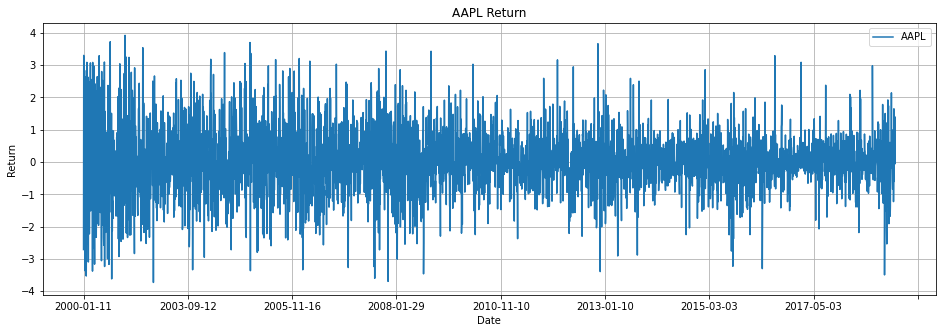

In [13]:
# Visualizing Log Returns for the DJIA 
plt.figure(figsize=(16, 5))
plt.title("AAPL Return")
plt.ylabel("Return")
rescaledDataset.AAPL.plot()
plt.grid(True);
plt.legend()
plt.show()

## Evaluate Algorithms and Models

  **Train Test Split:**

The portfolio is divided into train and test split to perform the analysis regarding the best porfolio and backtesting shown later.


In [14]:
# Dividing the dataset into training and testing sets
percentage = int(len(rescaledDataset) * 0.8)
X_train = rescaledDataset[:percentage]
X_test = rescaledDataset[percentage:]

X_train_raw = datareturns[:percentage]
X_test_raw = datareturns[percentage:]

stock_tickers = rescaledDataset.columns.values
n_tickers = len(stock_tickers)

##Model Evaluation- Applying Principle Component Analysis

As this step, we create a function to compute principle component analysis from sklearn. This function computes an inversed elbow chart that shows the amount of principle components and how many of them explain the variance treshold.


In [16]:
pca = PCA()
PrincipalComponent=pca.fit(X_train)

# First Principal Component /Eigenvector

pca.components_[0]


array([-0.2278224 , -0.22835766, -0.15302828, -0.18969933, -0.20200012,
       -0.17810558, -0.19508121, -0.16845303, -0.20820442, -0.19308548,
       -0.20879404, -0.20231768, -0.19939638, -0.19521427, -0.16686975,
       -0.22806024, -0.15153408, -0.169941  , -0.19367262, -0.17118841,
       -0.18993347, -0.16805969, -0.197612  , -0.22658993, -0.13821257,
       -0.16688803, -0.16897835, -0.16070821])

## **Explained Variance using PCA**



,Explained Variance
0,37.03%
1,42.75%
2,47.10%
3,51.08%
4,54.60%
5,57.74%
6,60.65%
7,63.44%
8,66.18%
9,68.71%


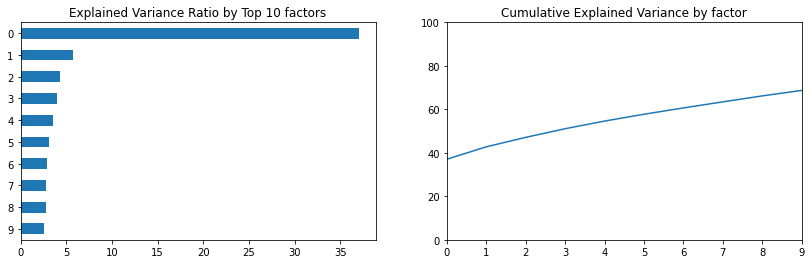

In [17]:
NumEigenvalues=10
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
Series1 = pd.Series(pca.explained_variance_ratio_[:NumEigenvalues]).sort_values()*100
Series2 = pd.Series(pca.explained_variance_ratio_[:NumEigenvalues]).cumsum()*100
Series1.plot.barh(ylim=(0,9), label="woohoo",title='Explained Variance Ratio by Top 10 factors',ax=axes[0]);
Series2.plot(ylim=(0,100),xlim=(0,9),ax=axes[1], title='Cumulative Explained Variance by factor');
# explained_variance
pd.Series(np.cumsum(pca.explained_variance_ratio_)).to_frame('Explained Variance').head(NumEigenvalues).style.format('{:,.2%}'.format)



We find that the most important factor explains around 40% of the daily return variation. The dominant factor is usually interpreted as ‘the market’, depending on the results of closer inspection.

The plot on the right shows the cumulative explained variance and indicates that around 10 factors explain 73% of the returns of this large cross-section of stocks.

**Looking at Portfolio weights**

We compute several functions to determine the weights of each principle component. We then visualize a scatterplot that visualizes an organized descending plot with the respective weight of every company at the current chosen principle component.


In [18]:
def PCWeights():
    '''
    Principal Components (PC) weights for each 28 PCs
    '''
    weights = pd.DataFrame()

    for i in range(len(pca.components_)):
        weights["weights_{}".format(i)] = pca.components_[i] / sum(pca.components_[i])

    weights = weights.values.T
    return weights

weights=PCWeights()

weights[0]



array([0.04341287, 0.04351486, 0.02916042, 0.0361483 , 0.03849228,
       0.03393904, 0.03717385, 0.03209969, 0.03967455, 0.03679355,
       0.0397869 , 0.0385528 , 0.03799613, 0.0371992 , 0.03179799,
       0.04345819, 0.02887569, 0.03238323, 0.03690543, 0.03262094,
       0.03619291, 0.03202474, 0.0376561 , 0.04317801, 0.0263372 ,
       0.03180147, 0.0321998 , 0.03062387])

In [19]:
pca.components_[0]

array([-0.2278224 , -0.22835766, -0.15302828, -0.18969933, -0.20200012,
       -0.17810558, -0.19508121, -0.16845303, -0.20820442, -0.19308548,
       -0.20879404, -0.20231768, -0.19939638, -0.19521427, -0.16686975,
       -0.22806024, -0.15153408, -0.169941  , -0.19367262, -0.17118841,
       -0.18993347, -0.16805969, -0.197612  , -0.22658993, -0.13821257,
       -0.16688803, -0.16897835, -0.16070821])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f99bb0e5410>],
      dtype=object)

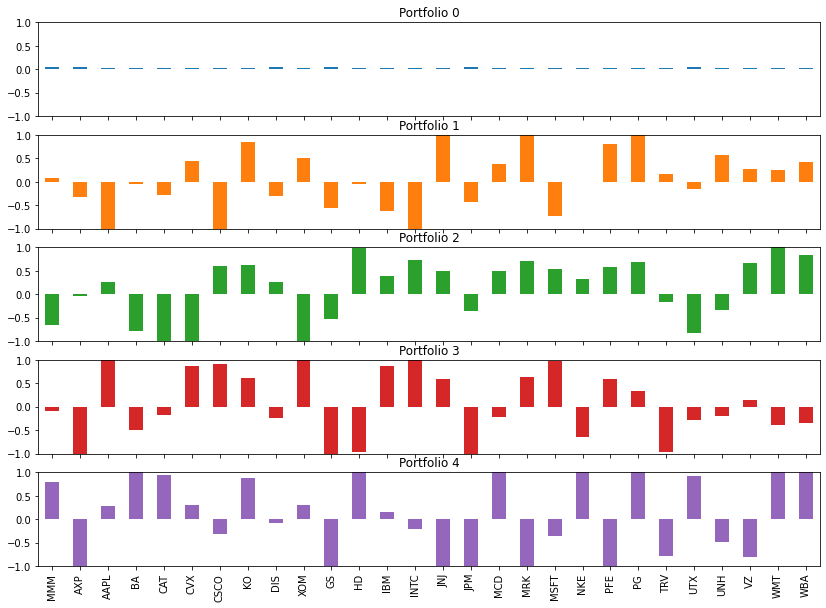

In [20]:
NumComponents=5
        
topPortfolios = pd.DataFrame(pca.components_[:NumComponents], columns=dataset.columns)
eigen_portfolios = topPortfolios.div(topPortfolios.sum(1), axis=0)
eigen_portfolios.index = [f'Portfolio {i}' for i in range( NumComponents)]
np.sqrt(pca.explained_variance_)
eigen_portfolios.T.plot.bar(subplots=True, layout=(int(NumComponents),1), figsize=(14,10), legend=False, sharey=True, ylim= (-1,1))

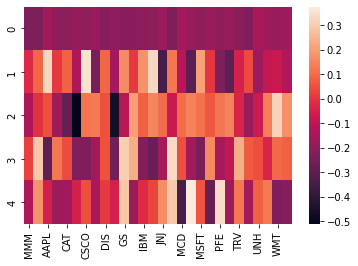

In [21]:
# plotting heatmap 
sns.heatmap(topPortfolios) 



**The heatmap and the plot above shown the contribution of different stocks in each eigenvector.**

## **Finding the Best Eigen Portfolio:**

In order to find the best eigen portfolios and perform backtesting in the next step, we use the sharpe ratio, which is a performance metric that explains the annualized returns against the annualized volatility of each company in a portfolio. A high sharpe ratio explains higher returns and/or lower volatility for the specified portfolio. The annualized sharpe ratio is computed by dividing the annualized returns against the annualized volatility. For annualized return we apply the geometric average of all the returns in respect to the periods per year (days of operations in the exchange in a year). Annualized volatility is computed by taking the standard deviation of the returns and multiplying it by the square root of the peri‐ ods per year.


In [23]:
# Sharpe Ratio
def sharpe_ratio(ts_returns, periods_per_year=252):
    '''
    Sharpe ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk.
    It calculares the annualized return, annualized volatility, and annualized sharpe ratio.
    
    ts_returns are  returns of a signle eigen portfolio.
    '''
    n_years = ts_returns.shape[0]/periods_per_year
    annualized_return = np.power(np.prod(1+ts_returns),(1/n_years))-1
    annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return / annualized_vol

    return annualized_return, annualized_vol, annualized_sharpe

We construct a loop to compute the principle component’s weights for each eigen portfolio, which then uses the sharpe ratio function to look for the portfolio with the highest sharpe ratio. Once we know which portfolio has the highest sharpe ratio, we can visualize its performance against the DJIA Index for comparison.


Eigen portfolio #0 with the highest Sharpe. Return 11.47%, vol = 13.31%, Sharpe = 0.86
    Return    Vol  Sharpe
0    0.115  0.133   0.862
7    0.096  0.693   0.138
5    0.100  0.845   0.118
1    0.057  0.670   0.084
2   -0.107  0.859  -0.124
11  -1.000  7.228  -0.138
13  -0.399  2.070  -0.193
25  -1.000  5.009  -0.200
23  -1.000  4.955  -0.202
6   -0.416  1.967  -0.212
10  -0.158  0.738  -0.213
3   -0.162  0.738  -0.220
26  -1.000  4.535  -0.220
8   -0.422  1.397  -0.302
17  -0.998  3.277  -0.305
24  -0.550  1.729  -0.318
16  -0.980  3.038  -0.323
21  -0.470  1.420  -0.331
14  -0.886  2.571  -0.345
27  -0.933  2.606  -0.358


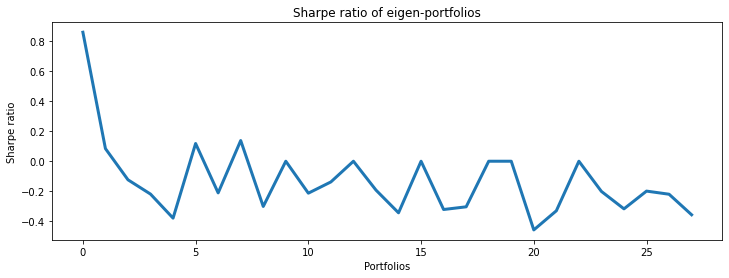

In [24]:
def optimizedPortfolio():
    n_portfolios = len(pca.components_)
    annualized_ret = np.array([0.] * n_portfolios)
    sharpe_metric = np.array([0.] * n_portfolios)
    annualized_vol = np.array([0.] * n_portfolios)
    highest_sharpe = 0 
    stock_tickers = rescaledDataset.columns.values
    n_tickers = len(stock_tickers)
    pcs = pca.components_
    
    for i in range(n_portfolios):
        
        pc_w = pcs[i] / sum(pcs[i])
        eigen_prtfi = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
        eigen_prtfi.sort_values(by=['weights'], ascending=False, inplace=True)
        eigen_prti_returns = np.dot(X_train_raw.loc[:, eigen_prtfi.index], pc_w)
        eigen_prti_returns = pd.Series(eigen_prti_returns.squeeze(), index=X_train_raw.index)
        er, vol, sharpe = sharpe_ratio(eigen_prti_returns)
        annualized_ret[i] = er
        annualized_vol[i] = vol
        sharpe_metric[i] = sharpe
        
        sharpe_metric= np.nan_to_num(sharpe_metric)
        
    # find portfolio with the highest Sharpe ratio
    highest_sharpe = np.argmax(sharpe_metric)

    print('Eigen portfolio #%d with the highest Sharpe. Return %.2f%%, vol = %.2f%%, Sharpe = %.2f' % 
          (highest_sharpe,
           annualized_ret[highest_sharpe]*100, 
           annualized_vol[highest_sharpe]*100, 
           sharpe_metric[highest_sharpe]))


    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    ax.plot(sharpe_metric, linewidth=3)
    ax.set_title('Sharpe ratio of eigen-portfolios')
    ax.set_ylabel('Sharpe ratio')
    ax.set_xlabel('Portfolios')

    results = pd.DataFrame(data={'Return': annualized_ret, 'Vol': annualized_vol, 'Sharpe': sharpe_metric})
    results.dropna(inplace=True)
    results.sort_values(by=['Sharpe'], ascending=False, inplace=True)
    print(results.head(20))

    plt.show()

optimizedPortfolio()





**As shown from the results above, the portfolio 12 is the best portfolio and has the maximum sharp ratio out of all the porfolio. Let us look at the composition of this portfolio.**


Sum of weights of current eigen-portfolio: 100.00


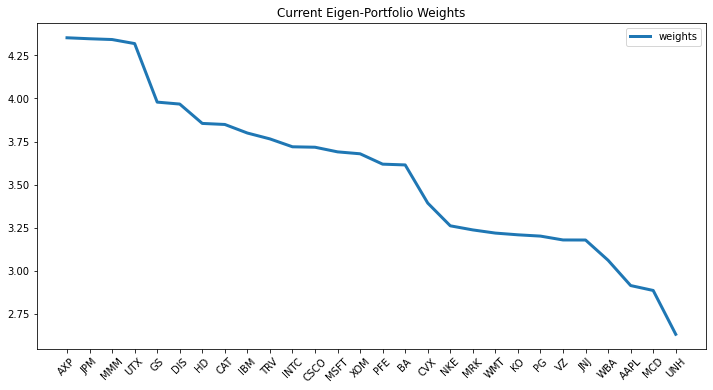

,weights
AXP,4.351
JPM,4.346
MMM,4.341
UTX,4.318
GS,3.979
DIS,3.967
HD,3.855
CAT,3.849
IBM,3.800
TRV,3.766


In [25]:
weights = PCWeights()
portfolio = portfolio = pd.DataFrame()

def plotEigen(weights, plot=False, portfolio=portfolio):
    portfolio = pd.DataFrame(data ={'weights': weights.squeeze()*100}, index = stock_tickers) 
    portfolio.sort_values(by=['weights'], ascending=False, inplace=True)
    if plot:
        print('Sum of weights of current eigen-portfolio: %.2f' % np.sum(portfolio))
        portfolio.plot(title='Current Eigen-Portfolio Weights', 
            figsize=(12,6), 
            xticks=range(0, len(stock_tickers),1), 
            rot=45, 
            linewidth=3
            )
        plt.show()


    return portfolio

# Weights are stored in arrays, where 0 is the first PC's weights.
plotEigen(weights=weights[0], plot=True)





The chart shows the allocation of the best portfolio. The weights in the chart are in percentages.

## **Backtesting Eigenportfolio:**

We will now try to backtest this algorithm on the test set, by looking at few top and bottom portfolios.



Current Eigen-Portfolio:
Return = 32.76%
Volatility = 68.64%
Sharpe = 0.48


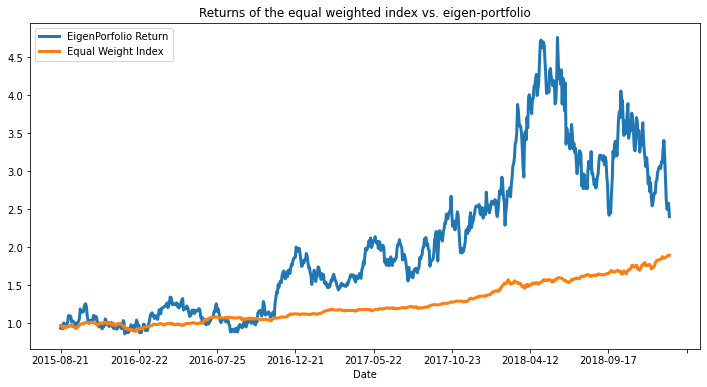

Current Eigen-Portfolio:
Return = 99.80%
Volatility = 58.34%
Sharpe = 1.71


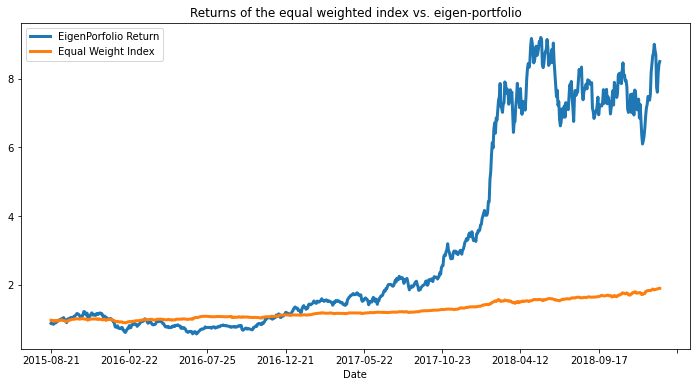

Current Eigen-Portfolio:
Return = -79.42%
Volatility = 185.30%
Sharpe = -0.43


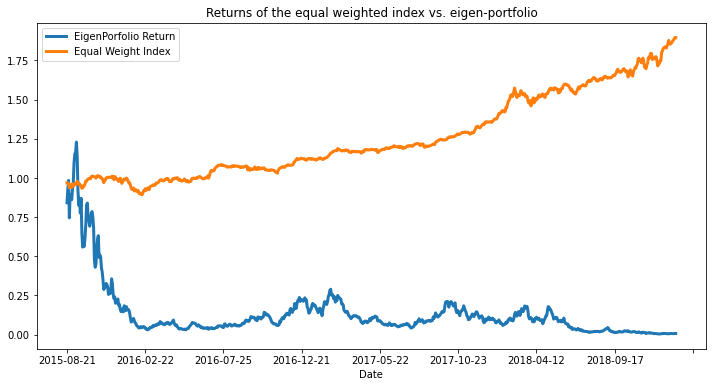

In [26]:
def Backtest(eigen):

    '''

    Plots Principle components returns against real returns.
    
    '''
   
    eigen_prtfi = pd.DataFrame(data ={'weights': eigen.squeeze()}, index = stock_tickers)
    eigen_prtfi.sort_values(by=['weights'], ascending=False, inplace=True)    

    eigen_prti_returns = np.dot(X_test_raw.loc[:, eigen_prtfi.index], eigen)
    eigen_portfolio_returns = pd.Series(eigen_prti_returns.squeeze(), index=X_test_raw.index)
    returns, vol, sharpe = sharpe_ratio(eigen_portfolio_returns)  
    print('Current Eigen-Portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (returns*100, vol*100, sharpe))
    equal_weight_return=(X_test_raw * (1/len(pca.components_))).sum(axis=1)    
    df_plot = pd.DataFrame({'EigenPorfolio Return': eigen_portfolio_returns, 'Equal Weight Index': equal_weight_return}, index=X_test.index)
    np.cumprod(df_plot + 1).plot(title='Returns of the equal weighted index vs. eigen-portfolio' , 
                          figsize=(12,6), linewidth=3)
    plt.show()
    
Backtest(eigen=weights[5])
Backtest(eigen=weights[1])
Backtest(eigen=weights[14])





**As shown in charts above the eigen portfolio return of the top portfolios outperform the equally weighted portfolio and the eigen portfolio ranked 19 underperformed the market significantly in the test set.**

## **Conclusion:**

**In terms of the intuition behind the eigen portfolios, we demonstrated that the first eigen portfolio represents a systematic risk factor and other eigen portfolio may represent sector or industry factor. We discuss diversification benefits offered by the eigen portfolios as they are derived using PCA and are independent.**

**Looking at the backtesting result, the portfolio with the best result in the training set leads to the best result in the test set. By using PCA, we get independent eigen portfo‐ lios with higher return and sharp ratio as compared to market.**
